# Cell type differences in PBMCs

### Load the data

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
data_path = '/data_volume/memento/demux/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read the data

In [6]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells', 'Dendritic cells', 'Megakaryocytes']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B', 'DC', 'Mega']))

In [7]:
def simplify_name(name):
    return name.split('.')[0]

In [8]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
# temp_adata = adata.copy()
# temp_adata = temp_adata[temp_adata.obs.cell == ct].copy()
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
# sc.pp.log1p(norm_adata)

In [10]:
adata.obs['ct'] = adata.obs['cell'].apply(lambda x: label_converter[x])

In [11]:
adata.shape

(24495, 35635)

In [12]:
adata.obs.cell.value_counts()

CD4 T cells          10342
CD14+ Monocytes       5341
B cells               2564
CD8 T cells           2035
NK cells              1988
FCGR3A+ Monocytes     1586
Dendritic cells        432
Megakaryocytes         207
Name: cell, dtype: int64

In [13]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

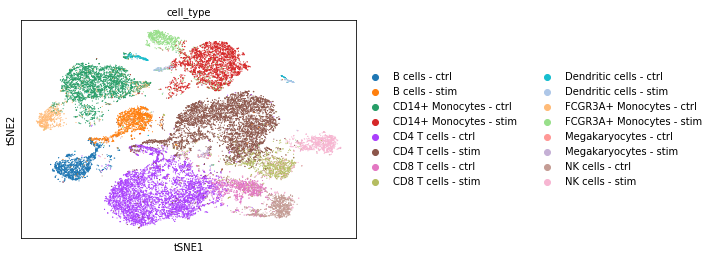

In [14]:
sc.pl.tsne(adata, color='cell_type')

In [15]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [16]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


In [17]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

### Cell type specific co-expression

for CD4 T cell:

gene_1, gene_2 = 'CXCR4', 'EEF1D'

gene_1, gene_2 = 'CXCR4', 'EEF1A1'

gene_1, gene_2 = 'PFDN5', 'OAZ1'

gene_1, gene_2 = 'UBB', 'OAZ1'

for CD14:

gene_1, gene_2 = 'EEF1D', 'BTG1'




### Read TFs

In [48]:
tf_df = pd.read_csv('../ifn_hbec/version3/baseline/human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

### Select control cells

In [49]:
cts = ['Tc', 'Th', 'B', 'ncM' 'cM']

In [50]:
ctrl_adata = adata[
    adata.obs['ct'].isin(cts) & \
    adata.obs['stim'].isin(['ctrl'])].copy().copy()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Setup memento

In [51]:
ctrl_adata.obs['q'] = 0.07

In [52]:
ctrl_adata.X = ctrl_adata.X.astype(float)

In [53]:
memento.setup_memento(ctrl_adata, q_column='q', trim_percent=0.1)

Version 0.0.6


### Read CT coexpression result

In [23]:
T_adata = sc.read(data_path + 'coex_markers_T.h5ad')

In [24]:
df = memento.get_2d_ht_result(T_adata)

In [37]:
moment_df = memento.get_2d_moments(T_adata, groupby='ct')

In [45]:
df.sort_values('corr_coef', ascending=False).head(5)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
5436,YPEL5,HSP90AB1,0.799156,0.095349,0.000092,0.006514
5464,YPEL5,DNAJA1,0.778140,0.096860,0.000076,0.006446
2214,JUN,UBE2D3,0.770475,0.112551,0.000038,0.006446
16114,HSP90AB1,STK17A,0.723727,0.092400,0.000373,0.008479
5490,YPEL5,HSPA8,0.701226,0.084225,0.000009,0.006446


In [44]:
moment_df.sort_values('ct_Tc').query('gene_1 == "JUN" & gene_2 == "UBE2D3"')

,gene_1,gene_2,ct_Th,ct_Tc,ct_B
2214,JUN,UBE2D3,0.481025,0.119698,-0.25259


In [39]:
T_adata.obs.ct.value_counts()

Th    5142
B     1303
Tc    1079
Name: ct, dtype: int64

In [40]:
moment_df.head(5)

,gene_1,gene_2,ct_Th,ct_Tc,ct_B
0,ISG15,ENO1,0.033491,0.111764,0.029329
1,ISG15,RPL11,-0.122045,-0.052054,0.223082
2,ISG15,SH3BGRL3,-0.024819,-0.049270,0.055793
3,ISG15,LAPTM5,-0.005389,0.016262,0.127024
4,ISG15,THRAP3,-0.081706,0.082009,0.074742


In [27]:
df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])

In [32]:
df.query('corr_fdr < 0.1').query('~gene_2.str.contains("RP")', engine='python').head(50)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
53,ISG15,HNRNPDL,0.225787,0.095805,0.021698,0.085910
71,ISG15,HLA-C,-0.244434,0.101687,0.018798,0.077452
100,ISG15,PABPC1,-0.144715,0.055482,0.017698,0.073961
157,ISG15,ALOX5AP,-0.165624,0.057563,0.012099,0.056404
246,ENO1,SH3BGRL3,0.396680,0.098237,0.000602,0.009709
247,ENO1,LAPTM5,0.313634,0.080599,0.000861,0.011195
249,ENO1,YBX1,-0.393425,0.092990,0.000574,0.009614
251,ENO1,PRDX1,-0.517514,0.110654,0.000265,0.007861
253,ENO1,SERBP1,-0.421506,0.160168,0.006599,0.036172
255,ENO1,S100A11,-0.246257,0.112084,0.026397,0.098818


### Test pairs of these highly expressed genes

In [23]:
simpflied_cts = ['T', 'B', 'M']

In [ ]:
for ct in simpflied_cts:
    
    labeled_ctrl_adata = ctrl_adata.copy().copy()
    labeled_ctrl_adata.obs['is_ct'] = labeled_ctrl_adata.obs['ct'].str.contains(ct).astype(int)
    
    memento.create_groups(labeled_ctrl_adata, label_columns=['ind', 'ct', 'is_ct'])
    
    memento.compute_1d_moments(labeled_ctrl_adata, min_perc_group=.9)
    
    memento.compute_2d_moments(labeled_ctrl_adata, list(itertools.combinations(labeled_ctrl_adata.var.index, 2)))
    
    memento.ht_2d_moments( 
        labeled_ctrl_adata, 
        formula_like='1 + ind + is_ct',
        treatment_col='is_ct', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    labeled_ctrl_adata.write(data_path + 'coex_markers_{}.h5ad'.format(ct))
    

[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    9.6s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   23.4s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:  1.3min
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:  2.2min
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:  2.8min
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:  3.7min
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  4.6min
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:  5.9min
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:  7.1min
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:  8.1min
[Parallel(n_jobs=94)]: Done 7012 tasks      | elapsed:  9.8min
[Parallel(n_jobs=94)]: Done 8262 tasks      | elapsed: 11.4min
[Parallel(n_jobs=94)]: Done 9612 tasks      | elapsed: 13.7min
[Parallel(n_jobs=94)]: Done 11062 tasks      | elapsed: 15.4min
[Parallel(n_jobs=94)]: Done 12612 tasks    

In [21]:
def plot_microscopy(X, c1, c2, s=5, q_up=.95, q_doawn=0.1, min_val=0.1, alpha=0.1, xlim=None, ylim=None, remove_axis=True):
    
    N = X.shape[0]
    
    c1 = np.clip(c1, a_min=np.quantile(c1, q_down), a_max=np.quantile(c1, q_up))
    c2 = np.clip(c2, a_min=np.quantile(c2, q_down), a_max=np.quantile(c2, q_up))

    c1 = (c1 - c1.min())/(c1.max()-c1.min())
    c2 = (c2 - c2.min())/(c2.max()-c2.min())
    
    c1 = np.clip(c1, a_min=min_val, a_max=1)
    c2 = np.clip(c2, a_min=min_val, a_max=1)
    
    plt.subplot(1, 3, 1); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([c1, np.zeros(N), np.zeros(N)]).T, s=s, alpha=alpha)
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
        
    plt.subplot(1, 3, 2); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([np.zeros(N), c2, np.zeros(N)]).T, s=s, alpha=alpha)
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
        
    plt.subplot(1, 3, 3); plt.scatter(X[:, 0], X[:, 1], c=np.vstack([c1, c2, np.zeros(N)]).T, s=s, alpha=alpha)
    plt.gca().set_facecolor((0, 0, 0))
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    
def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['cell', 'stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.125, 
        min_perc_group=0.99)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, ct, stim, ind = group.split('^')
        if ct not in cts:
            continue
        df_list.append((label_converter[ct], stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    df = pd.DataFrame(df_list, columns=['ct', 'stim','ind', 'corr']).sort_values('ct')
    df['corr'] = df['corr'].apply(lambda x: np.nan if abs(x) > 1 else x)
    
    return df
    

In [22]:
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(estimator)

adata_dict = {}
for ct in cts:
    print('Processing', ct)
    adata_ct =  adata[adata.obs.stim == 'ctrl'].copy()
#     adata_ct.obs['cell'] = np.random.choice(adata_ct.obs['cell'], adata_ct.shape[0], replace=False)
    adata_ct.obs['ct'] = adata_ct.obs['cell'].apply( lambda x: int(x == ct))# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
    scmemo.create_groups(adata_ct, label_columns=['ct', 'cell' ,'ind'], inplace=True)

    scmemo.compute_1d_moments(
        adata_ct, inplace=True, filter_genes=True, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.25, 
        min_perc_group=0.99)
    print('Size of data', adata_ct.shape)

    available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
    target_genes = adata_ct.var.index.tolist()
    target_genes = [gene for gene in target_genes if gene[:2] != 'RP' and gene[:3] != 'HLA']
    # target_genes = np.random.choice(target_genes, 50)
    print('TF list length', len(available_tfs))
    print('target gene length', len(target_genes))
    scmemo.compute_2d_moments(adata_ct, target_genes, target_genes)
    
    scmemo.ht_2d_moments(adata_ct, formula_like='1 + ct', cov_column='ct', num_boot=5000, num_cpus=6)
    adata_ct.write(data_path + 'result_2d/ct_specific_{}_05292020.h5ad'.format(label_converter[ct]))
    
    adata_dict[ct] = adata_ct.copy()

Processing CD4 T cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing CD14+ Monocytes
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.9s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing FCGR3A+ Monocytes
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.5s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing NK cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.3s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing CD8 T cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.7s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.4min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.3min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


Processing B cells
Size of data (12231, 138)
TF list length 0
target gene length 67


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    9.4s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  6.3min
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed: 14.2min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Done 2211 out of 2211 | elapsed: 19.8min finished
... storing 'scmemo_group' as categorical


In [13]:
adata_dict = {}
for ct in cts:
    adata_dict[ct] = sc.read(data_path + 'result_2d/ct_specific_{}_05292020.h5ad'.format(label_converter[ct]))

In [15]:
def get_2d_ht_result(adata):
	
	result_df = pd.DataFrame(
		itertools.product(
			adata.uns['scmemo']['2d_moments']['gene_1'],
			adata.uns['scmemo']['2d_moments']['gene_2']),
		columns=['gene_1', 'gene_2'])
	result_df['corr_coef'] = adata.uns['scmemo']['2d_ht']['corr_coef'].ravel()
	result_df['corr_pval'] = adata.uns['scmemo']['2d_ht']['corr_asl'].ravel()
	result_df['corr_fdr'] = util._fdrcorrect(result_df['corr_pval'].values)
	
	return result_df

In [18]:
for ct in cts:
    print(ct)
    print(get_2d_ht_result(adata_dict[ct]).query('corr_fdr < 0.15').shape)

CD4 T cells
(26, 5)
CD14+ Monocytes
(0, 5)
FCGR3A+ Monocytes
(2, 5)
NK cells
(0, 5)
CD8 T cells
(0, 5)
B cells
(2, 5)


In [ ]:
df = scmemo.get_2d_ht_result(adata_dict['CD4 T cells'])
df.query('corr_fdr < 0.2').sort_values('corr_coef')#.head(20)

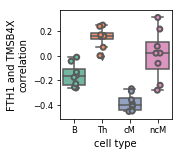

In [26]:
# EEF1A1	EEF1D

plt.figure(figsize=(2, 2))
gene_1, gene_2 = 'FTH1', 'TMSB4X'
plot_df = get_ct_ind_corr(adata_ct, gene_1, gene_2).query('ct in ["B","Th","cM","ncM"]')
sns.boxplot(x='ct', y='corr',
    data=plot_df, 
    palette='Set2')
sns.stripplot(x='ct', y='corr',
    data=plot_df, 
    palette='Set2', linewidth=2)
plt.ylabel('FTH1 and TMSB4X\ncorrelation')
plt.xlabel('cell type')
# plt.title('Correlation\nbetween\nFTH1 and TMSB4X')
plt.savefig(fig_path + 'fth1_tmsb4x.pdf', bbox_inches='tight')

In [27]:
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
# sc.pp.log1p(norm_adata)

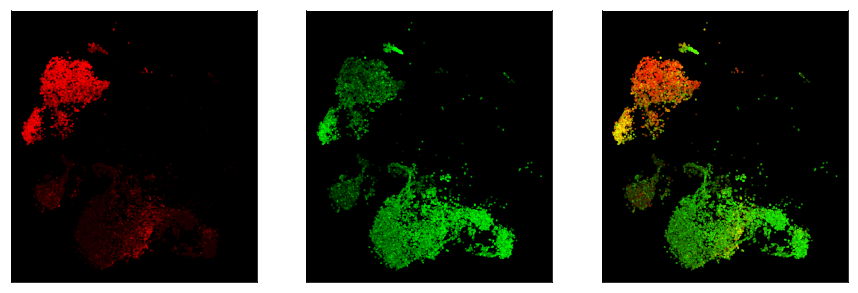

In [656]:
plt.figure(figsize=(15, 5))
plot_ct = 'CD14+ Monocytes'
dat = norm_adata[(norm_adata.obs.stim == 'ctrl')]
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.0,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True)

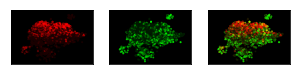

In [650]:
plt.figure(figsize=(5, 1))
plot_ct = 'CD14+ Monocytes'
dat = norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == plot_ct)]
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.5,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True,
    xlim=(-40, -5),ylim=(2, 37))
plt.savefig(fig_path + 'fth1_tmsb4x_cd14.pdf', bbox_inches='tight')

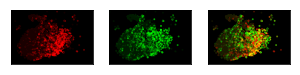

In [651]:
plt.figure(figsize=(5, 1))
plot_ct = 'CD4 T cells'
dat = norm_adata[(norm_adata.obs.stim == 'ctrl') & (norm_adata.obs.cell == plot_ct)]
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.5,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True,
    xlim=(-25, 25),ylim=(-40, 0))
plt.savefig(fig_path + 'fth1_tmsb4x_cd4.pdf', bbox_inches='tight')

### Scratch

In [34]:
norm_adata = adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
sc.pp.log1p(norm_adata)

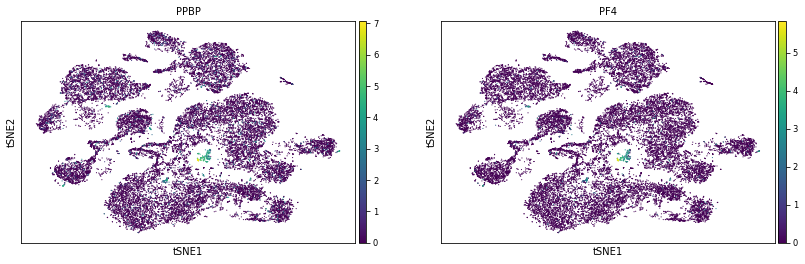

In [35]:
sc.pl.tsne(norm_adata, color=['PPBP', 'PF4'])

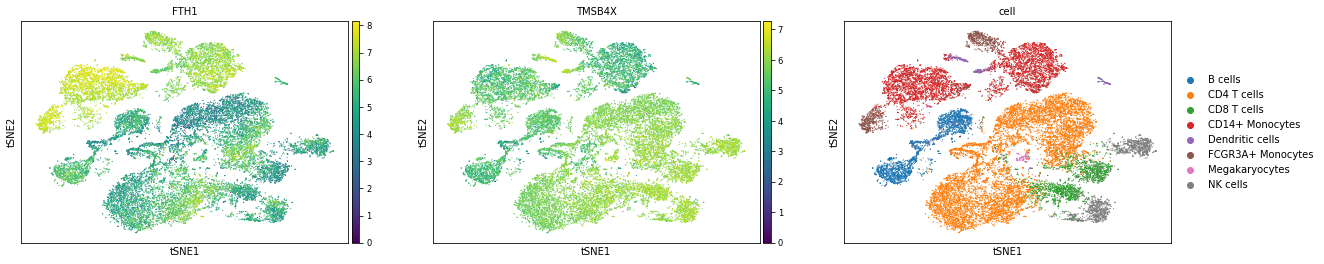

In [36]:
sc.pl.tsne(norm_adata, color=['FTH1', 'TMSB4X', 'cell'])